In [84]:
from pennylane import numpy as np
import pennylane as qml
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

## CV TRIAL

In [146]:
# load MNIST and filter digits 0 and 1
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [147]:
# # flatten images and normalize
# X_train = torch.stack([x.flatten() for x, y in trainset]).numpy()
# y_train = np.array([y for x, y in trainset], dtype=int)

# X_test = torch.stack([x.flatten() for x, y in testset]).numpy()
# y_test = np.array([y for x, y in testset], dtype=int)

# X_train_cv = X_train[:500]

# y_train_cv = y_train[:500]

# X_test_cv = X_test[:200]
# y_test_cv = y_test[:200]

# X_train_cv = X_train_cv / 255.0
# X_test_cv = X_test_cv / 255.0


# # encoder = OneHotEncoder(sparse=False, categories='auto')
# encoder = OneHotEncoder(sparse_output=False, categories='auto')
# y_train_encoded = encoder.fit_transform(y_train_cv.reshape(-1, 1))
# y_test_encoded = encoder.transform(y_test_cv.reshape(-1, 1))


In [151]:
training_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False)

In [152]:
# def show_mnist_batch(X, y, n=12):
#     plt.figure(figsize=(12, 5))

#     for i in range(n):
#         ax = plt.subplot(1, n, i+1)
#         img = X[i].reshape(28, 28)
#         ax.imshow(img, cmap='gray')
#         ax.set_title(f'label: {y[i].item()}')
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

In [153]:
# show_mnist_batch(X_train_cv, y_train_cv)

In [154]:
n_qumodes = 2
cutoff_dim = 10
dev_cv = qml.device('strawberryfields.fock', wires=n_qumodes, cutoff_dim=cutoff_dim)

n_params = 2 * n_qumodes
weights_cv = qml.numpy.array(np.random.uniform(-0.5, 0.5, n_params), requires_grad=True)
n_classes = 10
classical_weights = qml.numpy.array(np.random.randn(n_classes, n_qumodes), requires_grad=True)

@qml.qnode(dev_cv)
def cv_circuit(inputs, weights, interface="torch"):
    #squeezing and displacement
    for i in range(n_qumodes):
        qml.Displacement(np.pi * inputs[i], 0, wires=i)
        qml.Squeezing(weights[i], 0, wires=i)

    #entanglement layer (1 shared beamsplitter)
    qml.Beamsplitter(weights[0], 0, wires=[0, 1])

    #nonlinearity layer
    for i in range(n_qumodes):
        qml.Kerr(weights[n_qumodes + i], wires=i)

    # return [qml.expval(qml.X(wires=i)) for i in range(n_qumodes)]
    # return [qml.expval(qml.NumberOperator(wires=i)) for i in range(n_qumodes)]
    return qml.expval(qml.NumberOperator(0))

In [155]:
# n_qumodes = 1
# cutoff_dim = 10

# dev_cv = qml.device('strawberryfields.fock', wires=n_qumodes, cutoff_dim = cutoff_dim)

# opt_cv = qml.AdamOptimizer(stepsize=0.01)

# # n_params = 3
# n_params = 4
# weights_cv = qml.numpy.array(np.random.uniform(-0.5, 0.5, n_params), requires_grad=True)

# @qml.qnode(dev_cv)
# def cv_circuit(inputs, weights):
    
#     qml.Displacement(np.pi* inputs[0], 0, wires=0)
#     qml.Squeezing(weights[0], 0, wires=0)
#     qml.CubicPhase(weights[1], wires=0)
#     qml.Kerr(weights[2], wires=0)
    
#     # return qml.expval(qml.X(0))
#     x = qml.expval(qml.X(0))
#     return x

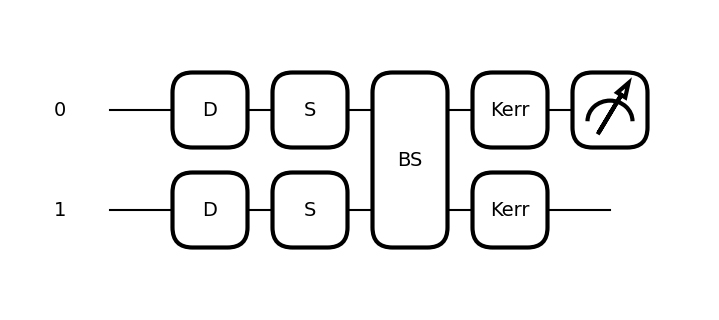

In [156]:
sample_inputs = X_train_cv[0]
# fig, ax = qml.draw_mpl(cv_circuit)(sample_inputs, sample_weights)
fig, ax = qml.draw_mpl(cv_circuit)(sample_inputs, weights_cv)

In [157]:
import torch.nn as nn
import torch.nn.functional as F

class CVQNet(nn.Module):
    def __init__(self, n_qumodes=2, n_classes=10):
        super().__init__()
        self.n_qumodes = n_qumodes
        self.n_classes = n_classes

        init_weights = 0.1 * torch.randn(2 * n_qumodes, dtype=torch.float64, requires_grad=True)
        self.q_weights = nn.Parameter(init_weights)

        self.fc = nn.Linear(n_qumodes, n_classes)

    def forward(self, x_batch):
        outputs = []

        for x in x_batch:
            q_out = cv_circuit(x, self.q_weights)
            # q_out = torch.stack(q_out)
            outputs.append(q_out)

        # q_outputs = torch.stack(outputs)
        q_outputs = q_out.float()
        
        return self.fc(q_outputs)

In [158]:
# model = CVQNet()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss()

# optimizer.zero_grad()
# logits = model(X_batch)
# loss = criterion(logits, y_batch)
# loss.backward()
# optimizer.step()

In [159]:
cv_model = CVQNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [161]:
def one_epoch(tloader, model, epochs):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(tloader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000
            print('batch{} loss: {}'.format(i+1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [140]:
# batch_size = 16
# epochs = 10

# loss_history_cv = []
# acc_history_cv = []

# for epoch in range(epochs):
#     epoch_loss = 0
#     all_preds = []
#     all_labels = []

#     perm = np.random.permutation(len(X_train_cv))
#     X_train_shuffled = X_train_cv[perm]
#     y_train_shuffled = y_train_encoded[perm]

#     with tqdm(range(0, len(X_train_cv), batch_size), desc=f'epoch {epoch + 1}/{epochs}') as pbar:
#         batch_x = X_train_shuffled[i:i+batch_size]
#         batch_y = y_train_shuffled[i:i+batch_size]

#         def cost(weights):
#             logits = qml.numpy.stack([cv_circuit(x, weights) for x in batch_x])
#             probs = softmax(logits)
#             return categorical_cross_entropy(batch_y, probs)

#         weights_cv, batch_loss = opt_cv.step_and_cost(cost, weights_cv)
#         epoch_loss += batch_loss

#         # logits = qml.numpy.stack([cv_circuit(x, weights_cv) for x in batch_x])
#         logits = qml.numpy.stack([qml.math.convert_like(cv_circuit(x, weights), 0.0) for x in batch_x])
#         probs = softmax(logits)
#         all_preds.append(probs)
#         all_labels.append(batch_y)

#         pbar.set_postfix(loss=f'{batch_loss:.4f}')

#     all_preds = np.vstack(all_preds)
#     all_labels = np.vstack(all_labels)
#     avg_loss = epoch_loss / (len(X_train_cv) / batch_size)
#     acc = multiclass_accuracy(all_labels, all_preds)

#     loss_history_cv.append(avg_loss)
#     acc_history_cv.append(acc)

#     tqdm.write(f'epoch {epoch + 1} - loss: {avg_loss:.4f} - acc: {acc:.4f}')

epoch 1/10:   0%|                                                                                                                                                                                                                                                                                                                                                                                         | 0/32 [00:00<?, ?it/s]


NameError: name 'i' is not defined